In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import math

In [2]:
# Wichtige Pfade zu Daten, Plots, etc.
path_to_data = '10.35097-1192/data/dataset/IndustrialElectricityConsumption.csv'
path_data_out = 'out'

# <div class="alert alert-block alert-warning"> Frage 1: Wie sieht ein typischer Stromverbrauchstag eines Industriebetriebs aus? Unterscheidet sich der Verbrauch am Wochenende deutlich von Werktagen? </div>
<b>To do:</b><br>
- [ ] Mittelwert pro Uhrzeit berechnen <br>
- [ ] Tagesprofil plotten<br>
- [ ] Peak-Zeiten markieren<br>

<b>To do:</b><br>
- [ ] Verbrauch Werktage vs Wochenende vergleichen<br>
- [ ] Interpretation: läuft Produktion durchgehend?<br>
- [ ] Erste Business-Frage: „Wann wird wirklich gearbeitet?“<br>

In [3]:
# 1) CSV einlesen (Semikolon-getrennt)
raw = pd.read_csv(path_to_data, sep=";", low_memory=False)

# 2) Label-Zeile extrahieren (enthält Branchenzuordnung UN_1..UN_28)
label_row = raw.loc[raw["Datum"].isna()].iloc[0]
unit_labels = label_row.filter(like="UN_").to_dict()

# 3) Nur echte Daten behalten
df = raw.loc[raw["Datum"].notna()].copy()

# 4) Datum und Uhrzeit sauber parsen
df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce")
df["timestamp"] = pd.to_datetime(df["Datum"].astype(str) + " " + df["Uhrzeit"], errors="coerce")

# 5) Index setzen (für Timeseries-Handling)
df = df.set_index("timestamp").sort_index()

# 6) Wochentag aus Datum-Spalte (nicht aus Index!)
df["weekday"] = df["Datum"].dt.weekday          # 0=Mo ... 6=So
df["is_weekend"] = df["weekday"] >= 5

# 7) Uhrzeit-Feature (für Tagesprofil)
df["time"] = df.index.time

# 8) UN-Spalten numerisch machen
un_cols = [c for c in df.columns if c.startswith("UN_")]
df[un_cols] = df[un_cols].apply(pd.to_numeric, errors="coerce")

df.head()

,Datum,Uhrzeit,UN_1,UN_2,UN_3,UN_4,UN_5,UN_6,UN_7,UN_8,...,UN_22,UN_23,UN_24,UN_25,UN_26,UN_27,UN_28,weekday,is_weekend,time
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:15:00,2014-01-01,00:15:00,50.0,16.0,28.8,50.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False,00:15:00
2014-01-01 00:30:00,2014-01-01,00:30:00,50.0,26.0,27.4,50.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False,00:30:00
2014-01-01 00:45:00,2014-01-01,00:45:00,49.0,12.0,27.6,52.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False,00:45:00
2014-01-01 01:00:00,2014-01-01,01:00:00,51.0,16.0,29.6,50.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False,01:00:00
2014-01-01 01:15:00,2014-01-01,01:15:00,50.0,18.0,33.0,51.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False,01:15:00


## Durchschnittliches Tagesprofil

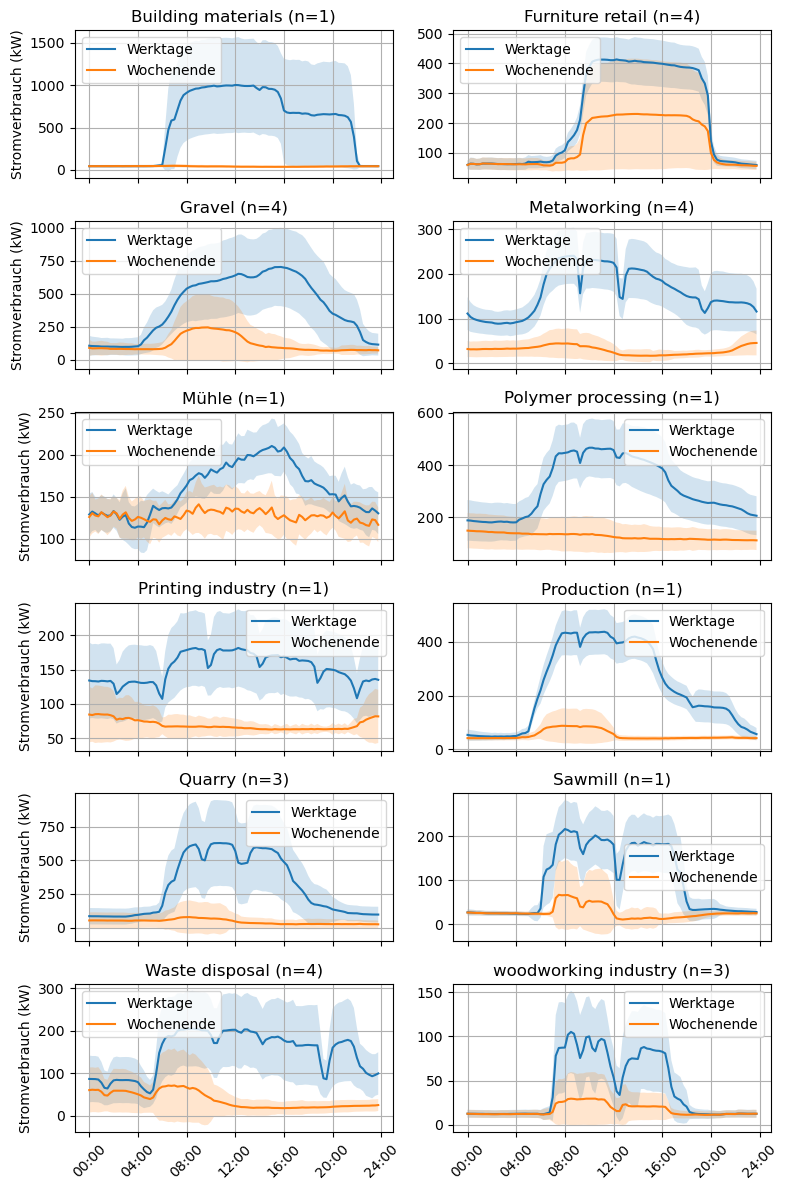

In [4]:
# --- Gruppen bauen: Branche -> UN-Spalten
industry_groups = defaultdict(list)
for unit, industry in unit_labels.items():
    if pd.notna(industry):
        industry_groups[industry].append(unit)

industries = sorted(industry_groups.keys())

# --- Hilfsfunktion: Minuten-Achse
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# --- Subplot Layout
n = len(industries)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(8, rows * 2), sharex=True)
axes = axes.flatten()

ticks = list(range(0, 24*60+1, 240))  # alle 4 Stunden
labels = [f"{m//60:02d}:00" for m in ticks]

for i, industry in enumerate(industries):
    ax = axes[i]
    units = industry_groups[industry]

    df_ind = df[units].copy()
    df_ind["time"] = df_ind.index.time
    df_ind["is_weekend"] = df_ind.index.weekday >= 5

    # --- Werktage
    weekday = df_ind[df_ind["is_weekend"] == False]
    weekday_grouped = weekday.groupby("time")[units]

    mean_weekday = weekday_grouped.mean().mean(axis=1)
    std_weekday  = weekday_grouped.std().mean(axis=1)

    # --- Wochenende
    weekend = df_ind[df_ind["is_weekend"] == True]
    weekend_grouped = weekend.groupby("time")[units]

    mean_weekend = weekend_grouped.mean().mean(axis=1)
    std_weekend  = weekend_grouped.std().mean(axis=1)

    # --- x-Achse (Minuten)
    x = [time_to_minutes(t) for t in mean_weekday.index]

    # --- Plot Werktage + Band
    ax.plot(x, mean_weekday.values, label="Werktage")
    ax.fill_between(
        x,
        mean_weekday.values - std_weekday.values,
        mean_weekday.values + std_weekday.values,
        alpha=0.2
    )

    # --- Plot Wochenende + Band
    ax.plot(x, mean_weekend.values, label="Wochenende")
    ax.fill_between(
        x,
        mean_weekend.values - std_weekend.values,
        mean_weekend.values + std_weekend.values,
        alpha=0.2
    )

    ax.set_title(f"{industry} (n={len(units)})")
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(True)
    #ax.set_ylim(0,1500) #selbe Skala

    if i % cols == 0:
        ax.set_ylabel("Stromverbrauch (kW)")

    ax.legend()

# Falls Subplots leer bleiben, entfernen
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# <div class="alert alert-block alert-warning"> Frage 2: Wie hoch ist der Stromverbrauch nachts, wenn die Firma eigentlich „aus“ sein sollte?

To Do: <br>
- [ ] Grundlast zwischen 0–4 Uhr bestimmen <br>
- [ ] Anteil am Gesamtverbrauch berechnen <br>
- [ ] Einsparpotenzial schätzen <br>
$\rightarrow$ Realistischer Nachhaltigkeits-Use-Case

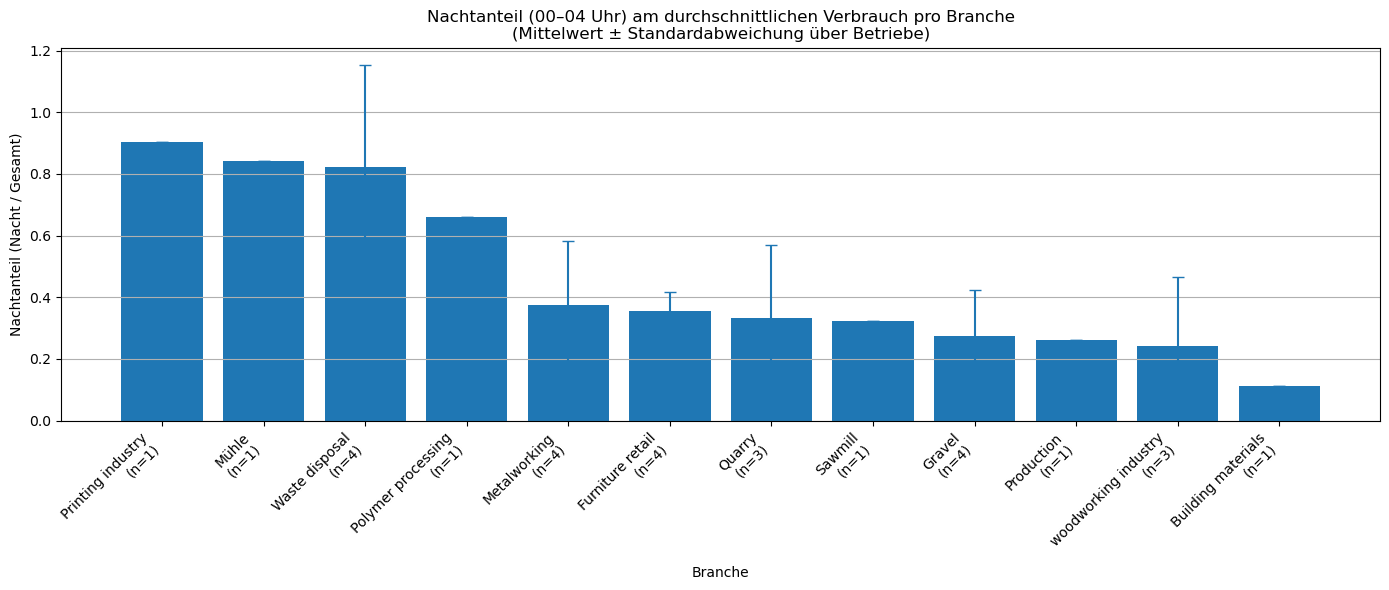

In [5]:
# --- 1) Gruppen: Branche -> UN-Spalten
groups = (
    pd.Series(unit_labels)
      .dropna()
      .groupby(lambda k: unit_labels[k])
      .apply(lambda s: list(s.index))
      .to_dict()
)

un_cols = [c for c in df.columns if c.startswith("UN_")]
# nur Units behalten, die wirklich im df sind
groups = {ind: [u for u in units if u in un_cols] for ind, units in groups.items()}
groups = {ind: units for ind, units in groups.items() if len(units) > 0}

# --- 2) Nachtfenster (00:00–03:59)
night_mask = df["time"].apply(lambda t: (t.hour >= 0) and (t.hour < 4))

# pro Unit: durchschnitt Nacht, duschschnitt Gesamt, Anteil Nacht
night_mean_per_unit = df.loc[night_mask, un_cols].mean(skipna=True)
overall_mean_per_unit = df[un_cols].mean(skipna=True)
night_ratio_per_unit = night_mean_per_unit / overall_mean_per_unit

per_unit = pd.DataFrame({
    "industry": pd.Series(unit_labels),
    "night_mean_0_4": night_mean_per_unit,
    "overall_mean": overall_mean_per_unit,
    "night_ratio": night_ratio_per_unit
}).dropna(subset=["industry"])

# --- 3) Aggregation pro Branche
# (Mittel/Median/Std über Betriebe derselben Branche)
by_industry = (
    per_unit.groupby("industry")
    .agg(
        n_units=("night_ratio", "size"),
        night_mean_0_4_mean=("night_mean_0_4", "mean"),
        night_mean_0_4_std=("night_mean_0_4", "std"),
        night_ratio_mean=("night_ratio", "mean"),
        night_ratio_median=("night_ratio", "median"),
        night_ratio_std=("night_ratio", "std"),
    )
    .sort_values("night_ratio_mean", ascending=False)
)

# --- 4) (Optional) Einsparpotenzial-Schätzer
# Ziel: nachts nur noch target_ratio * Tagesdurchschnitt (z.B. 0.2 = 20%)
target_ratio = 0.20
per_unit["target_night_mean"] = per_unit["overall_mean"] * target_ratio
per_unit["night_saving_abs"] = (per_unit["night_mean_0_4"] - per_unit["target_night_mean"]).clip(lower=0)

saving_by_industry = (
    per_unit.groupby("industry")
    .agg(
        night_saving_abs_mean=("night_saving_abs", "mean"),
        night_saving_abs_sum=("night_saving_abs", "sum"),
    )
)

# alles zusammenführen
by_industry = by_industry.join(saving_by_industry)

plot_df = by_industry.copy()

# NaNs bei std (z.B. wenn n=1) auf 0 setzen, sonst bricht errorbar
plot_df["night_ratio_std"] = plot_df["night_ratio_std"].fillna(0)

x = np.arange(len(plot_df))

plt.figure(figsize=(14, 6))
plt.bar(x, plot_df["night_ratio_mean"].values)
plt.errorbar(
    x,
    plot_df["night_ratio_mean"].values,
    yerr=plot_df["night_ratio_std"].values,
    fmt="none",
    capsize=4
)

plt.title("Nachtanteil (00–04 Uhr) am durchschnittlichen Verbrauch pro Branche\n(Mittelwert ± Standardabweichung über Betriebe)")
plt.xlabel("Branche")
plt.ylabel("Nachtanteil (Nacht / Gesamt)")

# Achsenbeschriftung inkl. n
labels = [f"{ind}\n(n={int(n)})" for ind, n in zip(plot_df.index, plot_df["n_units"])]
plt.xticks(x, labels, rotation=45, ha="right")

plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


In [6]:
display(
    (by_industry.assign(
        night_ratio_mean_pct=by_industry["night_ratio_mean"] * 100,
        night_ratio_std_pct=by_industry["night_ratio_std"] * 100
    )[["n_units","night_ratio_mean_pct","night_ratio_std_pct",
       "night_mean_0_4_mean","night_mean_0_4_std",
       "night_saving_abs_mean","night_saving_abs_sum"]]
     .sort_values("night_ratio_mean_pct", ascending=False))
)


,n_units,night_ratio_mean_pct,night_ratio_std_pct,night_mean_0_4_mean,night_mean_0_4_std,night_saving_abs_mean,night_saving_abs_sum
industry,,,,,,,
Printing industry,1,90.503559,NaN,116.120137,NaN,90.459237,90.459237
Mühle,1,84.193779,NaN,126.457789,NaN,96.418090,96.418090
Waste disposal,4,82.313127,32.867959,73.941755,59.170461,50.556222,202.224889
Polymer processing,1,65.929566,NaN,172.013953,NaN,119.832826,119.832826
Metalworking,4,37.391077,21.006897,76.181192,149.422879,51.939712,207.758847
Furniture retail,4,35.620797,6.250603,62.704232,80.676294,24.233305,96.933218
Quarry,3,33.276335,23.848645,75.547603,92.401386,41.224003,123.672008
Sawmill,1,32.429812,NaN,25.501507,NaN,9.774307,9.774307
Gravel,4,27.324129,14.969602,95.594092,93.217446,38.663166,154.652664


# <div class="alert alert-block alert-warning"> 3. Wie stark könnte das Unternehmen seine Lastspitzen senken, ohne Produktion abzuschalten?

To Do: <br>
- [ ] Höchste Peaks identifizieren<br>
- [ ] „Cap“ simulieren (z.B. max 90% Peak)<br>
- [ ] Einsparung in kW berechnen

In [7]:
un_cols = [c for c in df.columns if c.startswith("UN_")]

peak_per_unit = df[un_cols].max()
peak_per_unit.sort_values(ascending=False).head(10)

cap_factor = 0.90 # max.90%

caps = peak_per_unit * cap_factor
df_capped = df[un_cols].clip(upper=caps, axis=1)


In [8]:
savings_kw = df[un_cols] - df_capped

total_saving_kw = savings_kw.sum()
total_saving_kw.sort_values(ascending=False).head(10)

max_shaved_kw = savings_kw.max()
max_shaved_kw.sort_values(ascending=False).head(10)

result_units = pd.DataFrame({
    "peak_kw": peak_per_unit,
    "cap_kw": caps,
    "max_shaved_kw": max_shaved_kw,
    "total_shaved_kw_sum": total_saving_kw
})

result_units["relative_peak_reduction"] = result_units["max_shaved_kw"] / result_units["peak_kw"]

result_units.sort_values("max_shaved_kw", ascending=False).head(10)


,peak_kw,cap_kw,max_shaved_kw,total_shaved_kw_sum,relative_peak_reduction
UN_21,1756.00,1580.400,175.600,5657.200,0.1
UN_5,1652.00,1486.800,165.200,61273.600,0.1
UN_20,1633.84,1470.456,163.384,14017.448,0.1
UN_16,1585.00,1426.500,158.500,15192.000,0.1
UN_11,1508.00,1357.200,150.800,3397.200,0.1
UN_25,1242.09,1117.881,124.209,4653.772,0.1
UN_23,1186.00,1067.400,118.600,3904.400,0.1
UN_9,1168.00,1051.200,116.800,5188.920,0.1
UN_4,908.00,817.200,90.800,3698.800,0.1
UN_26,697.20,627.480,69.720,534.560,0.1


In [9]:
result_units["industry"] = pd.Series(unit_labels)

result_industry = (
    result_units.dropna(subset=["industry"])
    .groupby("industry")
    .agg(
        n_units=("peak_kw", "size"),
        peak_mean=("peak_kw", "mean"),
        cap_mean=("cap_kw", "mean"),
        max_shaved_mean=("max_shaved_kw", "mean"),
        total_shaved_sum=("total_shaved_kw_sum", "sum"),
        rel_reduction_mean=("relative_peak_reduction", "mean")
    )
    .sort_values("max_shaved_mean", ascending=False)
)

result_industry


,n_units,peak_mean,cap_mean,max_shaved_mean,total_shaved_sum,rel_reduction_mean
industry,,,,,,
Building materials,1,1652.000000,1486.80000,165.200000,61273.600000,0.1
Gravel,4,1194.100000,1074.69000,119.410000,13036.080000,0.1
Quarry,3,1074.553333,967.09800,107.455333,19824.655000,0.1
Polymer processing,1,697.200000,627.48000,69.720000,534.560000,0.1
Production,1,574.591500,517.13235,57.459150,814.152198,0.1
Furniture retail,4,534.825000,481.34250,53.482500,19678.210000,0.1
Waste disposal,4,409.500000,368.55000,40.950000,4716.900000,0.1
Printing industry,1,352.800000,317.52000,35.280000,312.640000,0.1
Sawmill,1,337.360000,303.62400,33.736000,260.952000,0.1


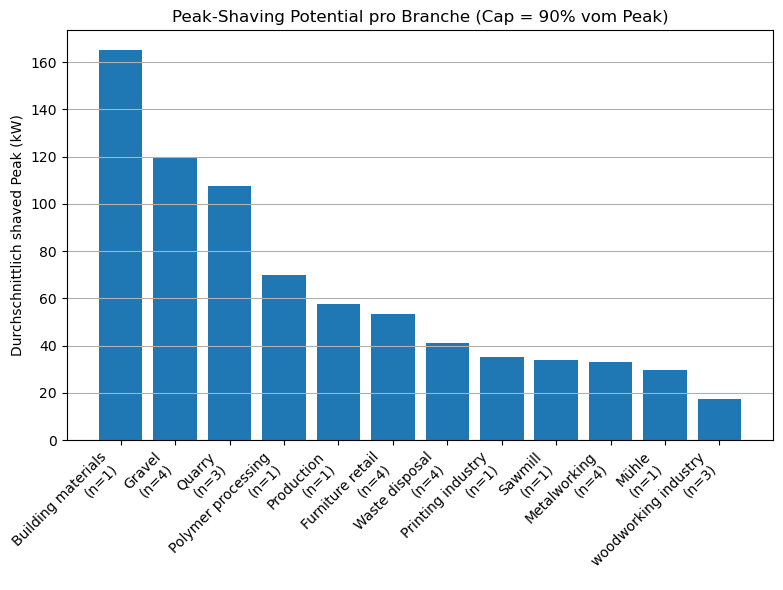

In [10]:

plot_df = result_industry.copy()
x = np.arange(len(plot_df))

plt.figure(figsize=(8,6))
plt.bar(x, plot_df["max_shaved_mean"].values)

labels = [f"{ind}\n(n={int(n)})" for ind, n in zip(plot_df.index, plot_df["n_units"])]
plt.xticks(x, labels, rotation=45, ha="right")

plt.title(f"Peak-Shaving Potential pro Branche (Cap = {int(cap_factor*100)}% vom Peak)")
plt.ylabel("Durchschnittlich shaved Peak (kW)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


In [11]:
leistungspreis = 100  # €/kW/Jahr (eine Beispielzahl einfach)

result_units["cost_saving_est_eur_year"] = result_units["max_shaved_kw"] * leistungspreis
result_units.sort_values("cost_saving_est_eur_year", ascending=False).head(10)

,peak_kw,cap_kw,max_shaved_kw,total_shaved_kw_sum,relative_peak_reduction,industry,cost_saving_est_eur_year
UN_21,1756.00,1580.400,175.600,5657.200,0.1,Gravel,17560.0
UN_5,1652.00,1486.800,165.200,61273.600,0.1,Building materials,16520.0
UN_20,1633.84,1470.456,163.384,14017.448,0.1,Quarry,16338.4
UN_16,1585.00,1426.500,158.500,15192.000,0.1,Furniture retail,15850.0
UN_11,1508.00,1357.200,150.800,3397.200,0.1,Gravel,15080.0
UN_25,1242.09,1117.881,124.209,4653.772,0.1,Quarry,12420.9
UN_23,1186.00,1067.400,118.600,3904.400,0.1,Gravel,11860.0
UN_9,1168.00,1051.200,116.800,5188.920,0.1,Metalworking,11680.0
UN_4,908.00,817.200,90.800,3698.800,0.1,Waste disposal,9080.0
UN_26,697.20,627.480,69.720,534.560,0.1,Polymer processing,6972.0


Die vorherige Methode ist ungeeignet, weil ein Cap von z.B. 90% des Peaks mathematisch immer eine maximale Reduktion von genau 10% erzwingt und dadurch das Ergebnis hauptsächlich davon abhängt, welche Branche einfach den höchsten absoluten Peak hat (größter Betrieb), statt zu zeigen, ob die Lastspitzen echte kurze Ausreißer sind, die man ohne Produktionsstopp realistisch glätten kann.

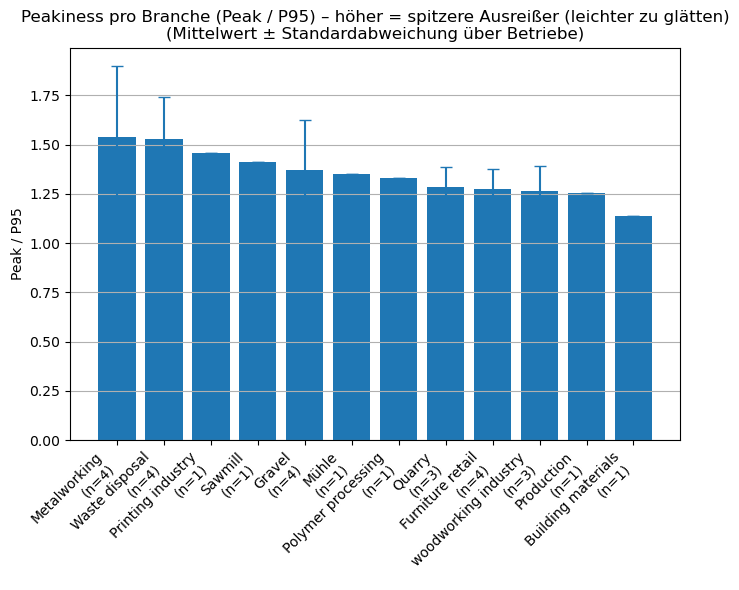

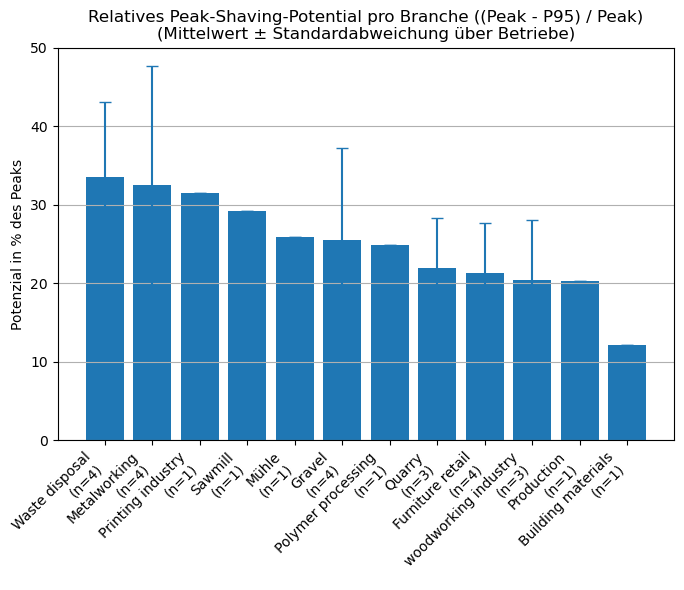

,n_units,peak_mean,p95_mean,peakiness_ratio_mean,peakiness_ratio_std,shave_potential_rel_mean,shave_potential_rel_std
industry,,,,,,,
Metalworking,4,331.500000,265.175000,1.541194,0.356259,0.325025,0.151253
Waste disposal,4,409.500000,296.650000,1.528274,0.212987,0.335719,0.095385
Printing industry,1,352.800000,241.600000,1.460265,0.000000,0.315193,NaN
Sawmill,1,337.360000,239.044000,1.411288,0.000000,0.291428,NaN
Gravel,4,1194.100000,936.300000,1.372193,0.251453,0.255112,0.117588
Mühle,1,298.184000,220.936000,1.349640,0.000000,0.259062,NaN
Polymer processing,1,697.200000,523.600000,1.331551,0.000000,0.248996,NaN
Quarry,3,1074.553333,857.015000,1.285817,0.100526,0.218967,0.063657
Furniture retail,4,534.825000,448.945000,1.277339,0.101377,0.213385,0.062942


In [12]:
un_cols = [c for c in df.columns if c.startswith("UN_")]

# --- Peakiness pro Betrieb (robust): Peak vs. P95
p95_per_unit  = df[un_cols].quantile(0.95)
peak_per_unit = df[un_cols].max()

peakiness_ratio = peak_per_unit / p95_per_unit                      # >1 => "spikier"
shave_potential_rel = (peak_per_unit - p95_per_unit) / peak_per_unit # Anteil des Peaks über P95

result_units_peakiness = pd.DataFrame({
    "industry": pd.Series(unit_labels),
    "p95_kw": p95_per_unit,
    "peak_kw": peak_per_unit,
    "peakiness_ratio": peakiness_ratio,
    "shave_potential_rel": shave_potential_rel
}).dropna(subset=["industry"])

# --- pro Branche aggregieren
result_industry_peakiness = (
    result_units_peakiness
    .groupby("industry")
    .agg(
        n_units=("peak_kw", "size"),
        peak_mean=("peak_kw", "mean"),
        p95_mean=("p95_kw", "mean"),
        peakiness_ratio_mean=("peakiness_ratio", "mean"),
        peakiness_ratio_std=("peakiness_ratio", "std"),
        shave_potential_rel_mean=("shave_potential_rel", "mean"),
        shave_potential_rel_std=("shave_potential_rel", "std"),
    )
)

# Sortierung: "spikiness" hoch = tendenziell leichteres Peak Shaving
plot_df = result_industry_peakiness.sort_values("peakiness_ratio_mean", ascending=False).copy()
plot_df["peakiness_ratio_std"] = plot_df["peakiness_ratio_std"].fillna(0)

# --- Plot: Peakiness-Ratio pro Branche (Mean +- Std)
x = np.arange(len(plot_df))
plt.figure(figsize=(7, 6))
plt.bar(x, plot_df["peakiness_ratio_mean"].values)
plt.errorbar(
    x,
    plot_df["peakiness_ratio_mean"].values,
    yerr=plot_df["peakiness_ratio_std"].values,
    fmt="none",
    capsize=4
)

labels = [f"{ind}\n(n={int(n)})" for ind, n in zip(plot_df.index, plot_df["n_units"])]
plt.xticks(x, labels, rotation=45, ha="right")
plt.title("Peakiness pro Branche (Peak / P95) – höher = spitzere Ausreißer (leichter zu glätten)\n(Mittelwert ± Standardabweichung über Betriebe)")
plt.ylabel("Peak / P95")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# --- Plot: Relatives Shaving-Potential (Peak - P95) / Peak in %
plot_df2 = result_industry_peakiness.sort_values("shave_potential_rel_mean", ascending=False).copy()
plot_df2["shave_potential_rel_std"] = plot_df2["shave_potential_rel_std"].fillna(0)

x2 = np.arange(len(plot_df2))
plt.figure(figsize=(7, 6))
plt.bar(x2, (plot_df2["shave_potential_rel_mean"].values * 100))
plt.errorbar(
    x2,
    (plot_df2["shave_potential_rel_mean"].values * 100),
    yerr=(plot_df2["shave_potential_rel_std"].values * 100),
    fmt="none",
    capsize=4
)

labels2 = [f"{ind}\n(n={int(n)})" for ind, n in zip(plot_df2.index, plot_df2["n_units"])]
plt.xticks(x2, labels2, rotation=45, ha="right")
plt.title("Relatives Peak-Shaving-Potential pro Branche ((Peak - P95) / Peak)\n(Mittelwert ± Standardabweichung über Betriebe)")
plt.ylabel("Potenzial in % des Peaks")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Tabelle anzeigen
display(plot_df[[
    "n_units",
    "peak_mean",
    "p95_mean",
    "peakiness_ratio_mean",
    "peakiness_ratio_std",
    "shave_potential_rel_mean",
    "shave_potential_rel_std"
]])


Das Unternehmen könnte je nach Branche ca. 20–35% der Lastspitzen reduzieren, ohne Produktion komplett abzuschalten, da die Peaks häufig Ausreißer über dem 95%-Quantil sind.
Besonders in Waste disposal, Metalworking und Printing industry sind Peaks deutlich stärker ausgeprägt (Peak/P95 ≈ 1.5), was auf kurzfristige, steuerbare Lasten hinweist.

# <div class="alert alert-block alert-warning"> Frage 4: Welche Prozesse könnte man in emissionsärmere Zeiten verschieben?

Basierend auf den Plots (Peak/P95 und relatives Peak-Shaving-Potenzial) zeigen insbesondere die Branchen **Waste disposal**, **Metalworking** und **Printing industry** hohe Werte, was darauf hindeutet, dass dort häufig **kurzzeitige Lastspitzen** auftreten, die sich relativ gut zeitlich verschieben lassen. 

Daher könnten in diesen Branchen vor allem **steuerbare, nicht kontinuierliche Prozesse** in emissionsärmere Zeiten verlagert werden, z.B. **Druckluft-Erzeugung (Kompressoren)**, **Pumpen und Fördertechnik**, **kurze Maschinenläufe wie Pressen, Schreddern oder Zerkleinern**, sowie **Batch-Prozesse wie Mischen, Mahlen oder Aufheizen/Trocknen**. 

Branchen mit geringerem Peak-Shaving-Potenzial wie **Building materials** deuten hingegen eher auf **konstante Grundlast** und kontinuierliche Prozesse hin, die sich deutlich schwieriger ohne Produktionsunterbrechung verschieben lassen.


# Playground Jelena

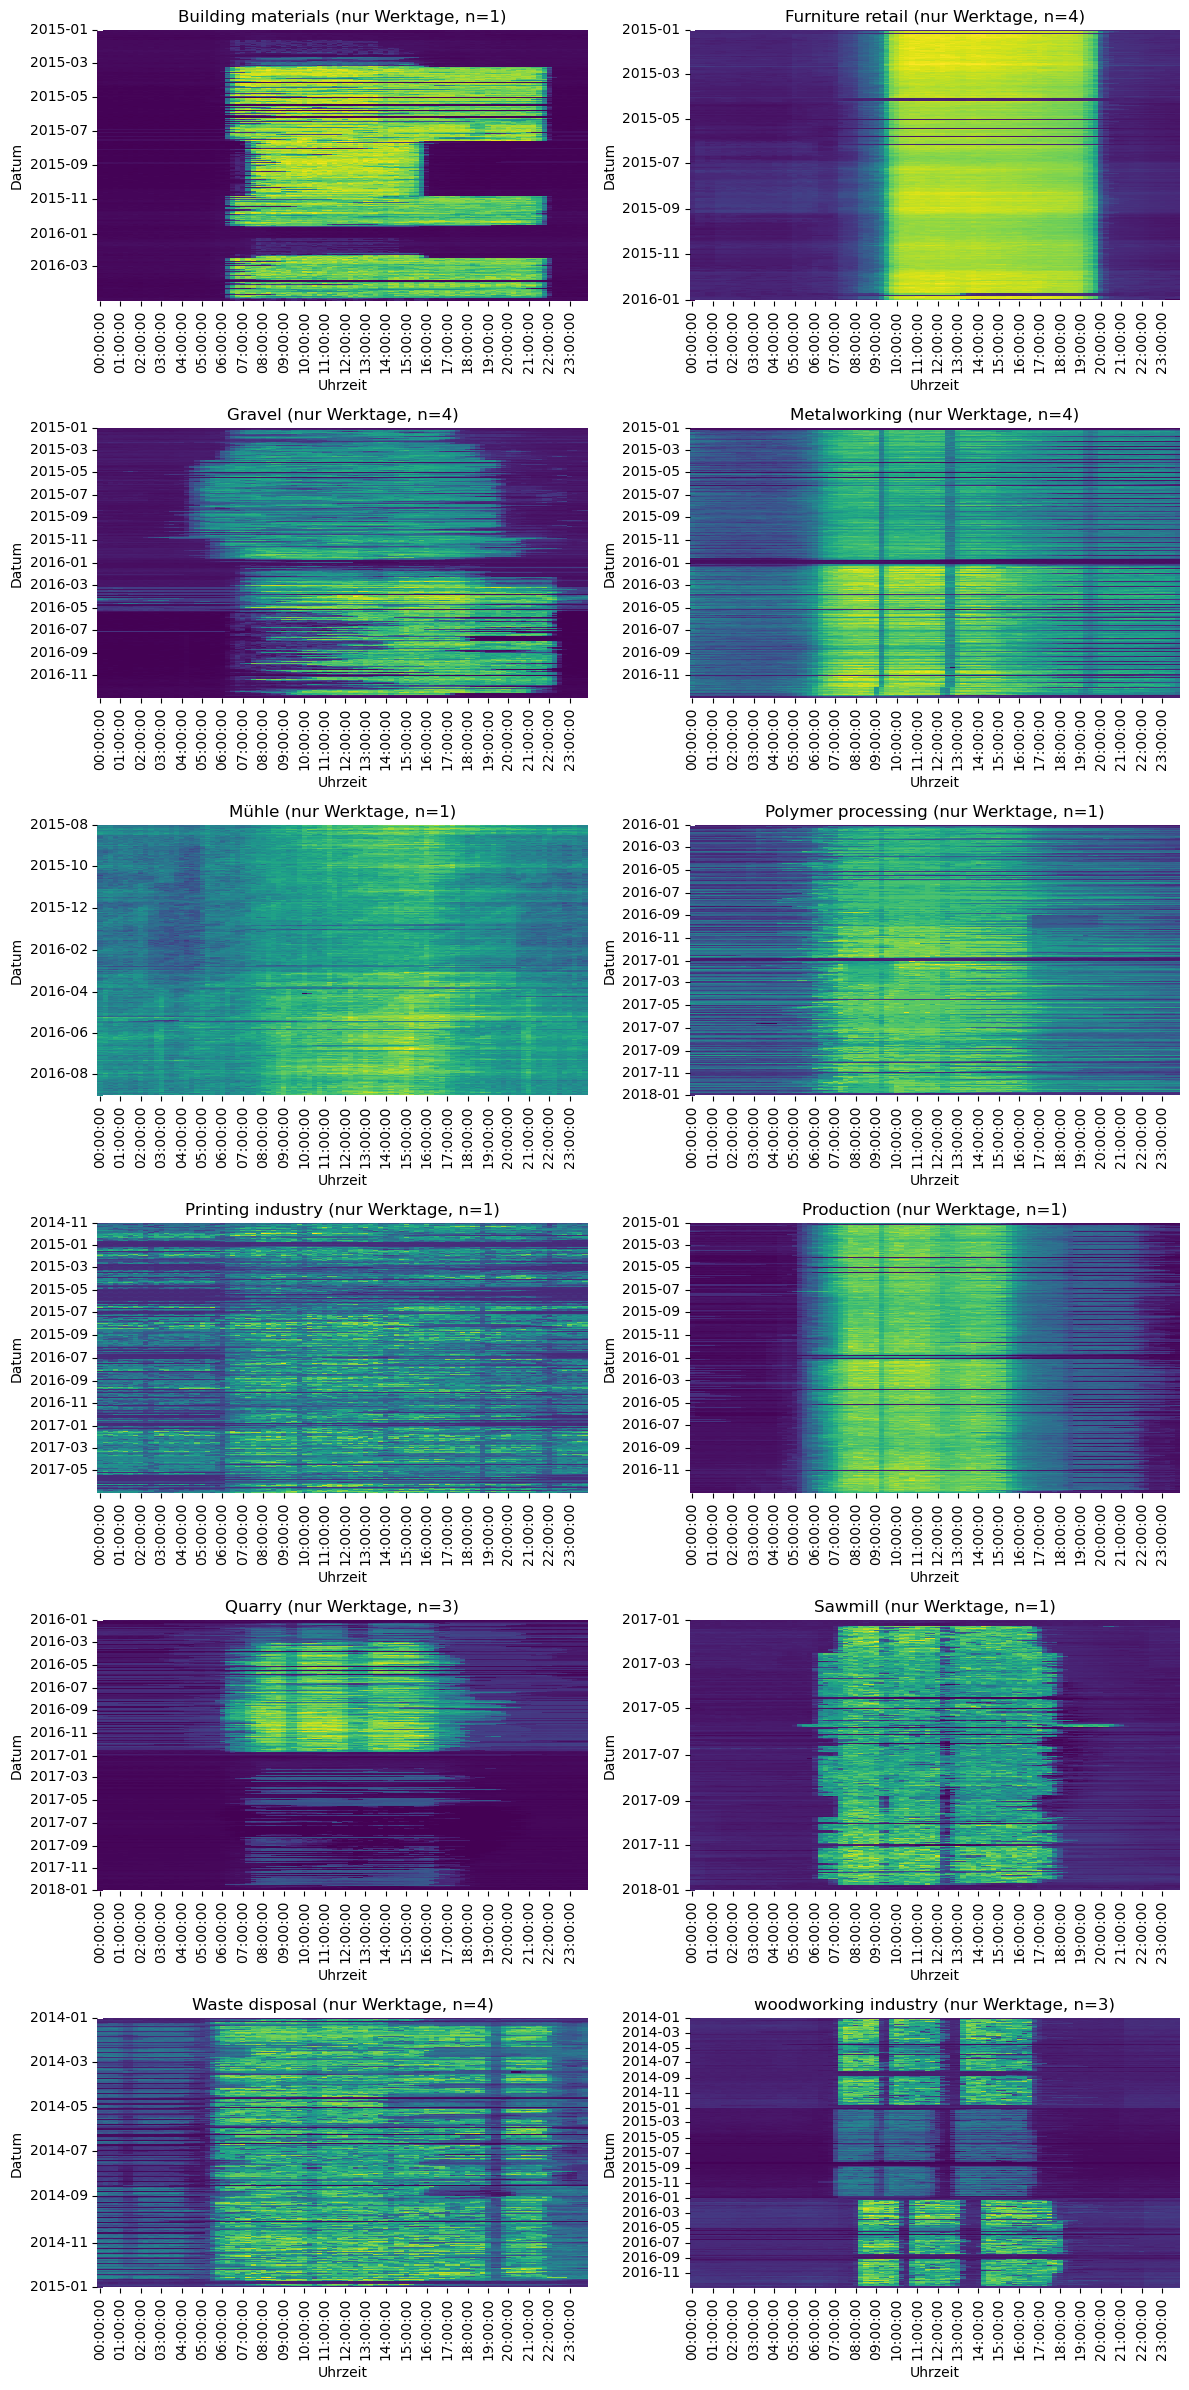

In [20]:
industries = sorted(groups.keys())

cols = 2
rows = math.ceil(len(industries) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for i, industry in enumerate(industries):
    units = groups[industry]

    # Branche aggregieren
    tmp = df[units].mean(axis=1).to_frame("load")
    tmp["date"] = pd.to_datetime(tmp.index.date)
    tmp["time"] = tmp.index.time

    # --- nur Werktage (Mo-Fr)
    tmp = tmp[tmp["date"].dt.weekday < 5]

    # Matrix für Heatmap
    matrix = tmp.pivot_table(index="date", columns="time", values="load", aggfunc="mean")

    ax = axes[i]
    sns.heatmap(matrix, cmap="viridis", ax=ax, cbar=False)

    ax.set_title(f"{industry} (nur Werktage, n={len(units)})")
    ax.set_xlabel("Uhrzeit")
    ax.set_ylabel("Datum")

    # --- y-Achse: nur jeder zweite Monat
    months = matrix.index.to_period("M")
    month_change_idx = [j for j in range(len(months)) if j == 0 or months[j] != months[j-1]]

    tick_positions = month_change_idx[::2]
    tick_labels = [matrix.index[j].strftime("%Y-%m") for j in tick_positions]

    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels, rotation=0)

# leere Subplots entfernen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


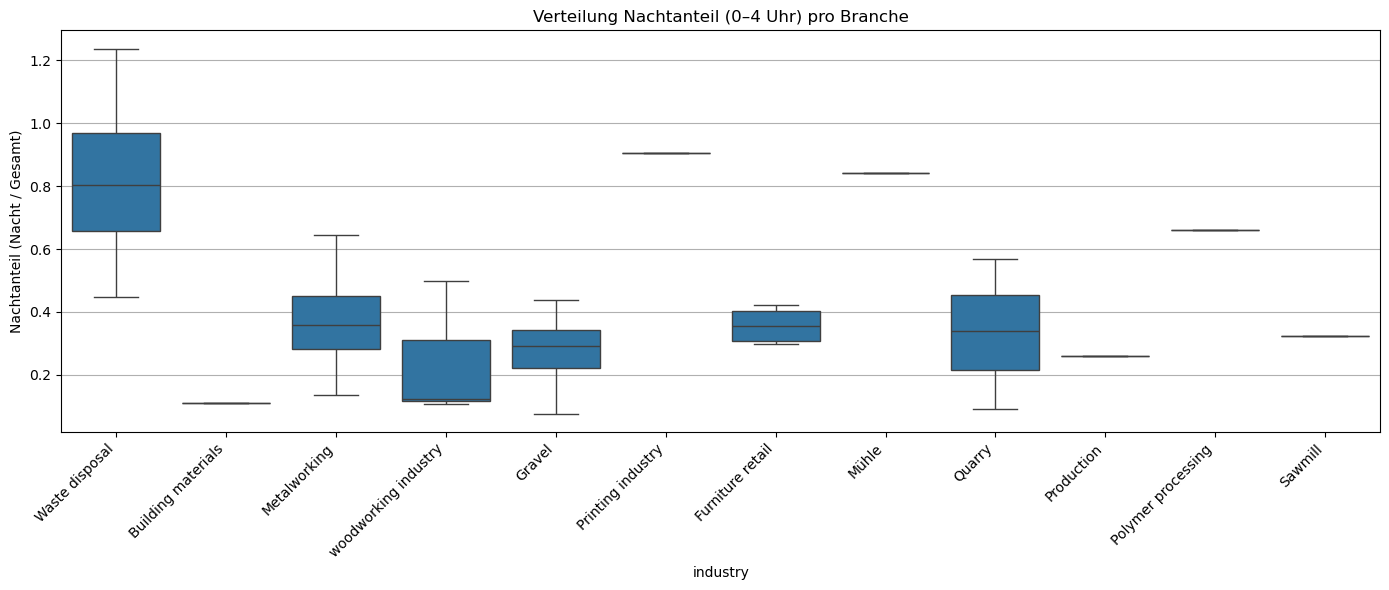

In [15]:
night_mask = df["time"].apply(lambda t: t.hour < 4)

night_mean = df.loc[night_mask, un_cols].mean()
overall_mean = df[un_cols].mean()
night_ratio = night_mean / overall_mean

ratios = pd.DataFrame({
    "unit": night_ratio.index,
    "night_ratio": night_ratio.values,
    "industry": [unit_labels[u] for u in night_ratio.index]
}).dropna()

plt.figure(figsize=(14,6))
sns.boxplot(data=ratios, x="industry", y="night_ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Verteilung Nachtanteil (0–4 Uhr) pro Branche")
plt.ylabel("Nachtanteil (Nacht / Gesamt)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


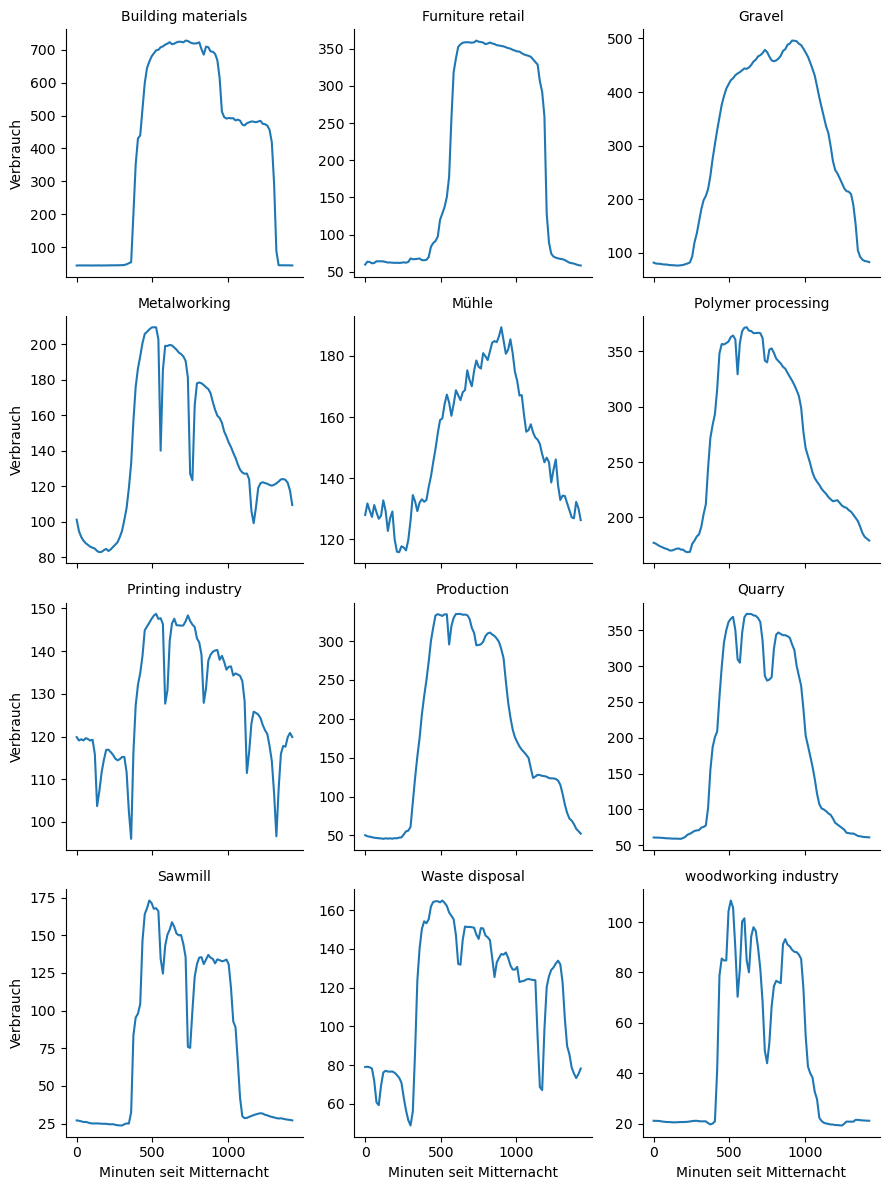

In [16]:
data = []

for ind, units in groups.items():
    for u in units:
        tmp = df[[u]].copy()
        tmp["industry"] = ind
        tmp["time"] = tmp.index.time
        tmp["value"] = tmp[u]
        data.append(tmp[["industry","time","value"]])

plot_df = pd.concat(data)

# Zeit in Minuten (damit seaborn schön plotten kann)
plot_df["time_min"] = plot_df["time"].apply(lambda t: t.hour*60 + t.minute)

# Mittelwert pro Branche und Uhrzeit
profile = plot_df.groupby(["industry","time_min"])["value"].mean().reset_index()

g = sns.FacetGrid(profile, col="industry", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="time_min", y="value")

g.set_titles("{col_name}")
g.set_axis_labels("Minuten seit Mitternacht", "Verbrauch")
plt.tight_layout()
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

industry = "Waste disposal"
units = groups[industry]

# Branche aggregieren
tmp = df[units].mean(axis=1).to_frame("load")
tmp["date"] = pd.to_datetime(tmp.index.date)
tmp["time"] = tmp.index.time

# nur Werktage
tmp = tmp[tmp["date"].dt.weekday < 5]

# Tagesmatrix: Zeilen=Datum, Spalten=Uhrzeit
daily_matrix = tmp.pivot_table(index="date", columns="time", values="load", aggfunc="mean")

# fehlende Werte auffüllen (z.B. falls Daten fehlen)
daily_matrix = daily_matrix.ffill(axis=1).bfill(axis=1)
print(daily_matrix)

time        00:00:00  00:15:00  00:30:00  00:45:00  01:00:00  01:15:00  \
date                                                                     
2014-01-01     36.20     36.20     38.35     35.15     36.65     38.00   
2014-01-02     33.70     35.10     38.25     33.60     33.20     36.05   
2014-01-03     50.05     48.45     49.00     49.05     50.60     47.10   
2014-01-06     41.55     40.45     40.65     43.55     44.00     42.65   
2014-01-07     36.80     36.35     37.00     37.25     38.65     38.00   
...              ...       ...       ...       ...       ...       ...   
2014-12-26     40.30     43.15     35.75     37.50     45.55     44.55   
2014-12-29     51.30     51.10     49.55     50.80     52.65     54.60   
2014-12-30     57.90     58.65     58.70     59.65     62.15     63.25   
2014-12-31     39.55     39.70     40.45     41.35     41.15     40.80   
2015-01-01     43.90     43.90     43.90     43.90     43.90     43.90   

time        01:30:00  01:45:00  02:00

In [23]:
X = daily_matrix.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

daily_matrix["cluster"] = clusters


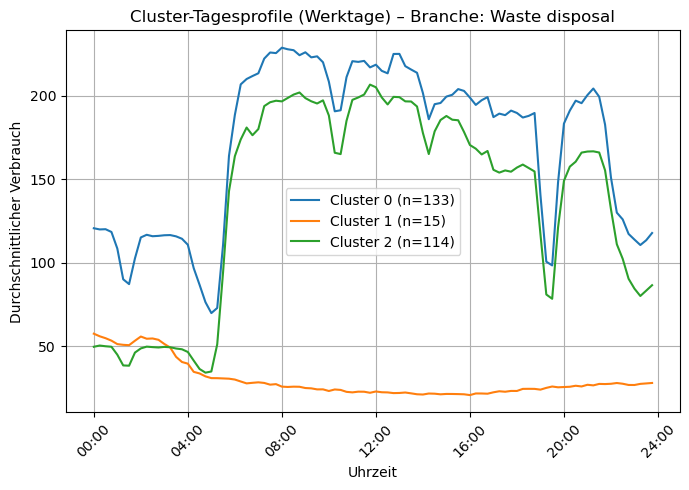

In [27]:
time_slots = daily_matrix.columns[:-1]  # ohne cluster
x = [t.hour*60 + t.minute for t in time_slots]

plt.figure(figsize=(7,5))

for c in range(k):
    mean_profile = daily_matrix[daily_matrix["cluster"] == c].iloc[:, :-1].mean()
    plt.plot(x, mean_profile.values, label=f"Cluster {c} (n={(clusters==c).sum()})")

ticks = list(range(0, 24*60+1, 240))
labels = [f"{m//60:02d}:00" for m in ticks]
plt.xticks(ticks, labels, rotation=45)

plt.title(f"Cluster-Tagesprofile (Werktage) – Branche: {industry}")
plt.xlabel("Uhrzeit")
plt.ylabel("Durchschnittlicher Verbrauch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


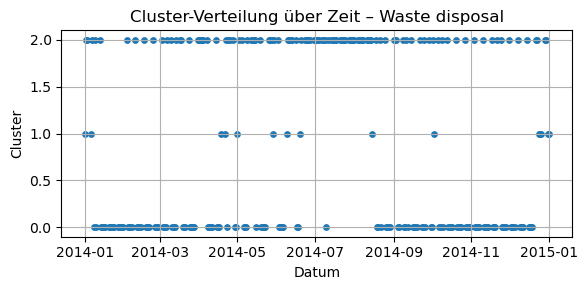

In [26]:
plt.figure(figsize=(6,3))
plt.scatter(daily_matrix.index, daily_matrix["cluster"], s=15)
plt.title(f"Cluster-Verteilung über Zeit – {industry}")
plt.xlabel("Datum")
plt.ylabel("Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()
